In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from hyperopt import fmin, tpe, hp
import ipynb.fs.full.utils as utils
import ipynb.fs.full.features as features
import ipynb.fs.full.features_distancias as f_distancias


df_train = pd.read_csv('./data/train_filtrado.csv')
# Para usarse con el submit a Kaggle
df_eval = pd.read_csv('./data/test.csv')

df_train, df_eval = features.features_de_csvs(df_train, df_eval)

df_train_idf = pd.read_csv('./data/train_idf.csv')
df_eval_idf = pd.read_csv('./data/test_idf.csv')

df_train = pd.merge(df_train, df_train_idf, on= 'id', how= 'left')
df_eval = pd.merge(df_eval, df_eval_idf, on= 'id', how= 'left')

# Randoms solo para asegurarse que los features esten bien hechos
# df_train = df_train.sample(frac=1).reset_index(drop=True)
# df_train = utils.dolarizar_df(df_train)
# df_train = df_train.sample(frac=1).reset_index(drop=True)

df_train, df_test = utils.dividir_df_testeo(df_train, test_size=0.01)

df_test = features.llenar_nulls(df_test, hgb_mean=True, df_fill=df_train)
df_train = features.llenar_nulls(df_train, hgb_mean=True)

In [2]:
# df_train = df_train.sample(frac=1).reset_index(drop=True)

df_test_f = features.features_independientes_precio(df_test)
df_test_f = features.features_dependientes_precio(df_test_f, df_train)

df_train_f = features.features_independientes_precio(df_train)
df_train_f = features.features_dependientes_precio(df_train_f, df_train)

df_test_f, cols_tipodepropiedad_ohe = features.columna_a_ohe(df_test_f, 'tipodepropiedad', N=100, df_aux=df_train, devolver_cols=True)
df_test_f, cols_provincia_ohe = features.columna_a_ohe(df_test_f, 'provincia', N=100, df_aux=df_train, devolver_cols=True)
df_test_f, cols_zona_ohe = features.columna_a_ohe(df_test_f, 'zona', df_aux=df_train_f, devolver_cols=True)

df_train_f = features.columna_a_ohe(df_train_f, 'tipodepropiedad', N=100, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'provincia', N=100, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'zona', df_aux=df_test_f)


df_train_f['fecha'] = pd.to_datetime(df_train_f['fecha']).astype(int)
df_test_f['fecha'] = pd.to_datetime(df_test_f['fecha']).astype(int)

# df_train_f = df_train_f.sample(frac=1).reset_index(drop=True)

df_train_f = f_distancias.feature_distancias(df_train_f)
df_test_f = f_distancias.feature_distancias(df_test_f, df_train_f)


## Búsqueda hiperparámetros

### RandomizedSearchCV

In [108]:
from sklearn.model_selection import RandomizedSearchCV


features = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'lat', 'lng', 'fecha', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'clustering_label', 'idf_titulo',
       'idf_descripcion', 'peso_titulo', 'peso_descripcion',
       'porcentaje_metros', 'diferencia_metros', 'metros_totales_normalizados',
       'metros_cubiertos_normalizados', 'escomercial',
       'promedio_metros_tipo_propiedad', 'promedio_metros_cub_tipo_propiedad',
       'prop_frecuente', 'top_provincia', 'es_ciudad_centrica',
       'promedio_metros_totales_provincia',
       'promedio_metros_cubiertos_provincia', 'mes', 'dia', 'trimestre',
       'dias_desde_datos', 'meses_desde_datos', 'antiguedad_bins_perc',
       'cantidad_inquilinos', 'tam_ambientes', 'promedio_precio_provincia',
       'promedio_precio_ciudad', 'varianza_precio_ciudad', 'count_ciudad',
       'promedio_id_zona', 'promedio_id_zona_gen', 'varianza_id_zona',
       'count_id_zona', 'promedio_precio_tipo_propiedad',
       'promedio_precio_tipo_propiedad_ciudad',
       'promedio_precio_tipo_propiedad_ciudad_gen', 'count_tipo_propiedad',
       'count_tipo_propiedad_ciudad', 'promedio_por_mes', 'varianza_por_mes',
       'promedio_precio_habitaciones',
       'promedio_precio_habitaciones_banos_garages',
       'promedio_precio_banos_garages', 'promedio_precio_hbg_tipo_propiedad',
       'lat_norm', 'lng_norm', 'promedio_precio_booleanos', 'puntaje',
       'distancia_ciudad_centrica', 'distancia_centro_mexico',
       'distancia_ciudad_cara']

lgb_params = {
    'boosting_type': ['gbdt'],
    'objective': ['regression'],
    'metric': ['mae'], # Si se deja vacio se toma el ideal para llegar al 'objective'
    'bagging_fraction': [0.1, 0.3, 0.5, 0.7, 0.9],
    'bagging_freq': [0, 1, 5, 10, 20, 40],
    'min_data_in_leaf': [10, 20, 40],
    'max_bin': [100, 175, 255, 364, 512],
    'reg_lambda': [0, 2, 6, 10, 15, 30, 40, 50],
    'min_split_gain': [0, 0.05, 0.1, 0.2, 0.4, 0.8],
    'feature_fraction': [0.85],
    'max_depth': [5, 10, 15],
    'num_leaves': [200, 300, 500],
    'learning_rate': [0.1, 0.15, 0.2, 0.25],
    'n_jobs': [4]
}

x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features, test_size=1)

rs_cv = RandomizedSearchCV(estimator=lgb.LGBMRegressor(),
                           param_distributions=lgb_params, 
                           cv=3, 
                           n_iter=200,
                           verbose=3, scoring='neg_mean_absolute_error')

rs_cv.fit(x_train, y_train, verbose=1)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV] reg_lambda=40, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=20, metric=mae, max_depth=5, max_bin=512, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  reg_lambda=40, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=20, metric=mae, max_depth=5, max_bin=512, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.5, score=-524843.980, total=   3.6s
[CV] reg_lambda=40, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=20, metric=mae, max_depth=5, max_bin=512, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV]  reg_lambda=40, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=20, metric=mae, max_depth=5, max_bin=512, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.5, score=-523405.530, total=   4.6s
[CV] reg_lambda=40, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=20, metric=mae, max_depth=5, max_bin=512, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.2s remaining:    0.0s


[CV]  reg_lambda=40, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=20, metric=mae, max_depth=5, max_bin=512, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.5, score=-525278.994, total=   3.3s
[CV] reg_lambda=40, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.05, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=175, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=0, bagging_fraction=0.1 
[CV]  reg_lambda=40, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.05, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=175, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=0, bagging_fraction=0.1, score=-487490.906, total=   8.1s
[CV] reg_lambda=40, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.05, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=175, learning_rate=0.1, feature_fraction=0.

[CV]  reg_lambda=10, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=5, max_bin=175, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=40, bagging_fraction=0.1, score=-553582.354, total=   2.1s
[CV] reg_lambda=10, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=5, max_bin=175, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=40, bagging_fraction=0.1 
[CV]  reg_lambda=10, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=5, max_bin=175, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=40, bagging_fraction=0.1, score=-548986.186, total=   2.3s
[CV] reg_lambda=10, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=5, max_bin=175, learning_rate=0.15, feature_fraction=0

[CV]  reg_lambda=6, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=20, metric=mae, max_depth=10, max_bin=175, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.3, score=-531682.456, total=   7.7s
[CV] reg_lambda=6, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=20, metric=mae, max_depth=10, max_bin=175, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.3 
[CV]  reg_lambda=6, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=20, metric=mae, max_depth=10, max_bin=175, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.3, score=-539646.658, total=  13.2s
[CV] reg_lambda=30, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.05, min_data_in_leaf=20, metric=mae, max_depth=10, max_bin=175, learning_rate=0.15, feature_fraction

[CV]  reg_lambda=6, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=20, metric=mae, max_depth=10, max_bin=175, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=40, bagging_fraction=0.5, score=-509310.251, total=   6.2s
[CV] reg_lambda=50, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=40, metric=mae, max_depth=15, max_bin=364, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.1 
[CV]  reg_lambda=50, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=40, metric=mae, max_depth=15, max_bin=364, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.1, score=-546371.923, total=   7.5s
[CV] reg_lambda=50, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=40, metric=mae, max_depth=15, max_bin=364, learning_rate=0.2, feature_fraction=0.

[CV]  reg_lambda=15, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=10, metric=mae, max_depth=15, max_bin=175, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=40, bagging_fraction=0.7, score=-499643.795, total=   7.3s
[CV] reg_lambda=15, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=10, metric=mae, max_depth=15, max_bin=175, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=40, bagging_fraction=0.7 
[CV]  reg_lambda=15, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=10, metric=mae, max_depth=15, max_bin=175, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=40, bagging_fraction=0.7, score=-502668.598, total=  10.4s
[CV] reg_lambda=15, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=10, metric=mae, max_depth=15, max_bin=175, learning_rate=0.25, feature_fracti

[CV]  reg_lambda=6, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=10, metric=mae, max_depth=10, max_bin=255, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.9, score=-483093.116, total=  10.5s
[CV] reg_lambda=6, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=10, metric=mae, max_depth=10, max_bin=255, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.9 
[CV]  reg_lambda=6, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=10, metric=mae, max_depth=10, max_bin=255, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.9, score=-486390.742, total=  11.1s
[CV] reg_lambda=30, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.2, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=100, learning_rate=0.25, feature_fraction=

[CV]  reg_lambda=15, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0, min_data_in_leaf=40, metric=mae, max_depth=5, max_bin=364, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=0, bagging_fraction=0.3, score=-516882.357, total=   7.9s
[CV] reg_lambda=6, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=20, metric=mae, max_depth=5, max_bin=512, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.1 
[CV]  reg_lambda=6, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=20, metric=mae, max_depth=5, max_bin=512, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.1, score=-557305.796, total=   3.4s
[CV] reg_lambda=6, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=20, metric=mae, max_depth=5, max_bin=512, learning_rate=0.2, feature_fraction=0.85, boost

[CV]  reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=20, metric=mae, max_depth=5, max_bin=255, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.5, score=-524811.889, total=   3.4s
[CV] reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=20, metric=mae, max_depth=5, max_bin=255, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.5 
[CV]  reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=20, metric=mae, max_depth=5, max_bin=255, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.5, score=-522981.857, total=   2.7s
[CV] reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=20, metric=mae, max_depth=5, max_bin=255, learning_rate=0.2, feature_fraction=0.85,

[CV]  reg_lambda=40, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=40, metric=mae, max_depth=15, max_bin=255, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.7, score=-490650.604, total=  10.1s
[CV] reg_lambda=40, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=40, metric=mae, max_depth=15, max_bin=255, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.7 
[CV]  reg_lambda=40, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=40, metric=mae, max_depth=15, max_bin=255, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.7, score=-493192.759, total=  10.0s
[CV] reg_lambda=10, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=10, metric=mae, max_depth=10, max_bin=175, learning_rate=0.1, feature_fraction=0

[CV]  reg_lambda=40, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=364, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=0, bagging_fraction=0.7, score=-492993.734, total=  11.9s
[CV] reg_lambda=2, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.05, min_data_in_leaf=40, metric=mae, max_depth=5, max_bin=255, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=0, bagging_fraction=0.1 
[CV]  reg_lambda=2, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.05, min_data_in_leaf=40, metric=mae, max_depth=5, max_bin=255, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=0, bagging_fraction=0.1, score=-527243.692, total=   5.0s
[CV] reg_lambda=2, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.05, min_data_in_leaf=40, metric=mae, max_depth=5, max_bin=255, learning_rate=0.1, feature_fraction=0.85, 

[CV]  reg_lambda=6, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=10, metric=mae, max_depth=10, max_bin=512, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.5, score=-515814.846, total=   9.6s
[CV] reg_lambda=6, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=10, metric=mae, max_depth=10, max_bin=512, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.5 
[CV]  reg_lambda=6, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=10, metric=mae, max_depth=10, max_bin=512, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.5, score=-514303.520, total=  10.0s
[CV] reg_lambda=6, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=10, metric=mae, max_depth=10, max_bin=512, learning_rate=0.25, feature_fraction=0

[CV]  reg_lambda=40, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0, min_data_in_leaf=10, metric=mae, max_depth=5, max_bin=255, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=5, bagging_fraction=0.9, score=-518213.742, total=   3.8s
[CV] reg_lambda=40, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0, min_data_in_leaf=10, metric=mae, max_depth=5, max_bin=255, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=5, bagging_fraction=0.9 
[CV]  reg_lambda=40, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0, min_data_in_leaf=10, metric=mae, max_depth=5, max_bin=255, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=5, bagging_fraction=0.9, score=-521061.347, total=   3.9s
[CV] reg_lambda=10, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.05, min_data_in_leaf=20, metric=mae, max_depth=5, max_bin=175, learning_rate=0.15, feature_fraction=0.85, boo

[CV]  reg_lambda=6, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.2, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=255, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=5, bagging_fraction=0.1, score=-554324.602, total=   4.7s
[CV] reg_lambda=2, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=175, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=5, bagging_fraction=0.5 
[CV]  reg_lambda=2, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=175, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=5, bagging_fraction=0.5, score=-490660.049, total=   6.3s
[CV] reg_lambda=2, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=175, learning_rate=0.1, feature_fraction=0.85, b

[CV]  reg_lambda=50, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.05, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=255, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.7, score=-489855.765, total=   8.7s
[CV] reg_lambda=50, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.05, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=255, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.7 
[CV]  reg_lambda=50, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.05, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=255, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.7, score=-488217.673, total=   9.2s
[CV] reg_lambda=50, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.05, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=255, learning_rate=0.15, feature_fr

[CV]  reg_lambda=10, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=20, metric=mae, max_depth=10, max_bin=255, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.1, score=-544411.934, total=   3.5s
[CV] reg_lambda=10, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=20, metric=mae, max_depth=10, max_bin=255, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.1 
[CV]  reg_lambda=10, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=20, metric=mae, max_depth=10, max_bin=255, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.1, score=-549600.803, total=   3.8s
[CV] reg_lambda=40, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=10, metric=mae, max_depth=15, max_bin=255, learning_rate=0.2, feature_fractio

[CV]  reg_lambda=15, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=255, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.7, score=-487907.871, total=  11.1s
[CV] reg_lambda=6, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=20, metric=mae, max_depth=10, max_bin=512, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.7 
[CV]  reg_lambda=6, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=20, metric=mae, max_depth=10, max_bin=512, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.7, score=-488079.340, total=  14.8s
[CV] reg_lambda=6, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=20, metric=mae, max_depth=10, max_bin=512, learning_rate=0.15, feature_fraction=0

[CV]  reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.2, min_data_in_leaf=10, metric=mae, max_depth=5, max_bin=255, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.5, score=-525828.918, total=   3.0s
[CV] reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.2, min_data_in_leaf=10, metric=mae, max_depth=5, max_bin=255, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.5 
[CV]  reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.2, min_data_in_leaf=10, metric=mae, max_depth=5, max_bin=255, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.5, score=-521908.083, total=   3.2s
[CV] reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.2, min_data_in_leaf=10, metric=mae, max_depth=5, max_bin=255, learning_rate=0.25, feature_fraction=0

[CV]  reg_lambda=10, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=512, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.1, score=-518056.757, total=   6.6s
[CV] reg_lambda=10, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=512, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.1 
[CV]  reg_lambda=10, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=512, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.1, score=-522671.463, total=   8.2s
[CV] reg_lambda=40, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=175, learning_rate=0.2, feature_fraction=0.85

[CV]  reg_lambda=6, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=10, metric=mae, max_depth=10, max_bin=100, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.7, score=-508536.005, total=   5.2s
[CV] reg_lambda=10, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=10, metric=mae, max_depth=5, max_bin=100, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.1 
[CV]  reg_lambda=10, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=10, metric=mae, max_depth=5, max_bin=100, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.1, score=-542355.406, total=   1.7s
[CV] reg_lambda=10, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=10, metric=mae, max_depth=5, max_bin=100, learning_rate=0.1, feature_fraction=0.85, 

[CV]  reg_lambda=15, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.05, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=255, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=40, bagging_fraction=0.3, score=-528971.949, total=   6.9s
[CV] reg_lambda=15, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.05, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=255, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=40, bagging_fraction=0.3 
[CV]  reg_lambda=15, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.05, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=255, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=40, bagging_fraction=0.3, score=-528694.245, total=   6.7s
[CV] reg_lambda=15, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.05, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=255, learning_rate=0.25, feature_fr

[CV]  reg_lambda=0, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=175, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=5, bagging_fraction=0.9, score=-488986.326, total=  11.6s
[CV] reg_lambda=0, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=175, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=5, bagging_fraction=0.9 
[CV]  reg_lambda=0, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=175, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=5, bagging_fraction=0.9, score=-489009.196, total=   8.2s
[CV] reg_lambda=6, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=20, metric=mae, max_depth=10, max_bin=100, learning_rate=0.2, feature_fraction=0.85,

[CV]  reg_lambda=2, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=10, metric=mae, max_depth=5, max_bin=255, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=40, bagging_fraction=0.3, score=-536150.092, total=   3.3s
[CV] reg_lambda=15, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.2, min_data_in_leaf=20, metric=mae, max_depth=5, max_bin=100, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=5, bagging_fraction=0.3 
[CV]  reg_lambda=15, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.2, min_data_in_leaf=20, metric=mae, max_depth=5, max_bin=100, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=5, bagging_fraction=0.3, score=-531474.910, total=   4.0s
[CV] reg_lambda=15, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.2, min_data_in_leaf=20, metric=mae, max_depth=5, max_bin=100, learning_rate=0.25, feature_fraction=0.85,

[CV]  reg_lambda=2, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=10, metric=mae, max_depth=15, max_bin=364, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.7, score=-489337.423, total=  11.7s
[CV] reg_lambda=2, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=10, metric=mae, max_depth=15, max_bin=364, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.7 
[CV]  reg_lambda=2, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=10, metric=mae, max_depth=15, max_bin=364, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.7, score=-490884.974, total=  11.4s
[CV] reg_lambda=2, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=10, metric=mae, max_depth=15, max_bin=364, learning_rate=0.15, feature_fraction=0

[CV]  reg_lambda=50, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=20, metric=mae, max_depth=10, max_bin=100, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.5, score=-494493.539, total=   4.7s
[CV] reg_lambda=50, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=20, metric=mae, max_depth=10, max_bin=100, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.5 
[CV]  reg_lambda=50, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=20, metric=mae, max_depth=10, max_bin=100, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.5, score=-498309.908, total=   4.8s
[CV] reg_lambda=40, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0, min_data_in_leaf=20, metric=mae, max_depth=5, max_bin=364, learning_rate=0.1, feature_fraction=0.85, b

[CV]  reg_lambda=40, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0, min_data_in_leaf=20, metric=mae, max_depth=5, max_bin=175, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=5, bagging_fraction=0.9, score=-523722.271, total=   3.4s
[CV] reg_lambda=0, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=175, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.7 
[CV]  reg_lambda=0, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=175, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.7, score=-496363.872, total=   5.9s
[CV] reg_lambda=0, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=175, learning_rate=0.2, feature_fraction=0.85, boosting_

[CV]  reg_lambda=15, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=100, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.7, score=-490427.618, total=   5.3s
[CV] reg_lambda=15, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=100, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.7 
[CV]  reg_lambda=15, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=100, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.7, score=-490655.205, total=   5.7s
[CV] reg_lambda=15, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=100, learning_rate=0.15, feature_fracti

[CV]  reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=15, max_bin=512, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.7, score=-486213.037, total=  15.6s
[CV] reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=15, max_bin=512, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.7 
[CV]  reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=15, max_bin=512, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.7, score=-491656.504, total=  16.9s
[CV] reg_lambda=10, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=512, learning_rate=0.15, feature_fracti

[CV]  reg_lambda=10, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.2, min_data_in_leaf=40, metric=mae, max_depth=15, max_bin=100, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=0, bagging_fraction=0.9, score=-490747.855, total=   6.3s
[CV] reg_lambda=50, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=15, max_bin=364, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=5, bagging_fraction=0.1 
[CV]  reg_lambda=50, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=15, max_bin=364, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=5, bagging_fraction=0.1, score=-553241.155, total=   3.6s
[CV] reg_lambda=50, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=15, max_bin=364, learning_rate=0.25, feature_fraction=0

[CV]  reg_lambda=40, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0, min_data_in_leaf=10, metric=mae, max_depth=5, max_bin=175, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.9, score=-531655.830, total=   3.0s
[CV] reg_lambda=40, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0, min_data_in_leaf=10, metric=mae, max_depth=5, max_bin=175, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.9 
[CV]  reg_lambda=40, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0, min_data_in_leaf=10, metric=mae, max_depth=5, max_bin=175, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.9, score=-528759.183, total=   2.8s
[CV] reg_lambda=40, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0, min_data_in_leaf=10, metric=mae, max_depth=5, max_bin=175, learning_rate=0.1, feature_fraction=0.85, boostin

[CV]  reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0, min_data_in_leaf=10, metric=mae, max_depth=15, max_bin=100, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.5, score=-491059.102, total=   7.6s
[CV] reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0, min_data_in_leaf=10, metric=mae, max_depth=15, max_bin=100, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.5 
[CV]  reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0, min_data_in_leaf=10, metric=mae, max_depth=15, max_bin=100, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.5, score=-493908.740, total=   7.2s
[CV] reg_lambda=40, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=10, metric=mae, max_depth=15, max_bin=175, learning_rate=0.1, feature_fraction=0.85, b

[CV]  reg_lambda=30, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=40, metric=mae, max_depth=5, max_bin=175, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=5, bagging_fraction=0.9, score=-519649.827, total=   3.0s
[CV] reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=40, metric=mae, max_depth=15, max_bin=364, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.7 
[CV]  reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=40, metric=mae, max_depth=15, max_bin=364, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.7, score=-485810.174, total=  10.7s
[CV] reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=40, metric=mae, max_depth=15, max_bin=364, learning_rate=0.1, feature_fraction=0.85,

[CV]  reg_lambda=6, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=364, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.9, score=-485564.173, total=  13.2s
[CV] reg_lambda=6, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=364, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.9 
[CV]  reg_lambda=6, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=364, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.9, score=-483536.803, total=  11.3s
[CV] reg_lambda=6, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=364, learning_rate=0.1, feature_fraction=0.85, bo

[CV]  reg_lambda=6, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=5, max_bin=175, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=5, bagging_fraction=0.1, score=-555976.890, total=   1.7s
[CV] reg_lambda=6, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=5, max_bin=175, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=5, bagging_fraction=0.1 
[CV]  reg_lambda=6, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.8, min_data_in_leaf=40, metric=mae, max_depth=5, max_bin=175, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=5, bagging_fraction=0.1, score=-561874.383, total=   1.8s
[CV] reg_lambda=40, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.05, min_data_in_leaf=40, metric=mae, max_depth=5, max_bin=100, learning_rate=0.2, feature_fraction=0.85, boos

[CV]  reg_lambda=15, objective=regression, num_leaves=500, n_jobs=4, min_split_gain=0.1, min_data_in_leaf=20, metric=mae, max_depth=10, max_bin=255, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=40, bagging_fraction=0.3, score=-520576.606, total=   5.0s
[CV] reg_lambda=50, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=40, metric=mae, max_depth=5, max_bin=100, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=0, bagging_fraction=0.7 
[CV]  reg_lambda=50, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=40, metric=mae, max_depth=5, max_bin=100, learning_rate=0.1, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=0, bagging_fraction=0.7, score=-530928.365, total=   2.7s
[CV] reg_lambda=50, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=40, metric=mae, max_depth=5, max_bin=100, learning_rate=0.1, feature_fraction=0.85, 

[CV]  reg_lambda=50, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0, min_data_in_leaf=10, metric=mae, max_depth=15, max_bin=100, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.9, score=-488942.068, total=   6.2s
[CV] reg_lambda=50, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0, min_data_in_leaf=10, metric=mae, max_depth=15, max_bin=100, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.9 
[CV]  reg_lambda=50, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0, min_data_in_leaf=10, metric=mae, max_depth=15, max_bin=100, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.9, score=-488431.127, total=   6.3s
[CV] reg_lambda=50, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0, min_data_in_leaf=10, metric=mae, max_depth=15, max_bin=100, learning_rate=0.2, feature_fraction=0.85, boo

[CV]  reg_lambda=15, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=100, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.9, score=-488180.473, total=   5.3s
[CV] reg_lambda=15, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=100, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.9 
[CV]  reg_lambda=15, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0, min_data_in_leaf=40, metric=mae, max_depth=10, max_bin=100, learning_rate=0.15, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=20, bagging_fraction=0.9, score=-488851.305, total=   9.0s
[CV] reg_lambda=15, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.2, min_data_in_leaf=40, metric=mae, max_depth=15, max_bin=100, learning_rate=0.2, feature_fraction=0.85

[CV]  reg_lambda=30, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.2, min_data_in_leaf=10, metric=mae, max_depth=15, max_bin=512, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=1, bagging_fraction=0.9, score=-493737.226, total=  10.0s
[CV] reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0, min_data_in_leaf=10, metric=mae, max_depth=10, max_bin=175, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.7 
[CV]  reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0, min_data_in_leaf=10, metric=mae, max_depth=10, max_bin=175, learning_rate=0.25, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.7, score=-494670.378, total=   5.3s
[CV] reg_lambda=50, objective=regression, num_leaves=300, n_jobs=4, min_split_gain=0, min_data_in_leaf=10, metric=mae, max_depth=10, max_bin=175, learning_rate=0.25, feature_fraction=0.85

[CV]  reg_lambda=30, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=100, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.7, score=-492907.855, total=   5.4s
[CV] reg_lambda=30, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=100, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.7 
[CV]  reg_lambda=30, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=100, learning_rate=0.2, feature_fraction=0.85, boosting_type=gbdt, bagging_freq=10, bagging_fraction=0.7, score=-491748.750, total=   5.4s
[CV] reg_lambda=30, objective=regression, num_leaves=200, n_jobs=4, min_split_gain=0.4, min_data_in_leaf=20, metric=mae, max_depth=15, max_bin=100, learning_rate=0.2, feature_fraction=0

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 69.0min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg_...
                                        'max_bin': [100, 175, 255, 364, 512],
                                        'max_depth': [5, 10, 15],
                                    

In [110]:
display(rs_cv.best_params_)
from sklearn.externals import joblib
# Guarda el modelo
joblib.dump(rs_cv, 'lightgbm_rscv.pkl', compress=1)

{'reg_lambda': 50,
 'objective': 'regression',
 'num_leaves': 500,
 'n_jobs': 4,
 'min_split_gain': 0.4,
 'min_data_in_leaf': 20,
 'metric': 'mae',
 'max_depth': 15,
 'max_bin': 512,
 'learning_rate': 0.2,
 'feature_fraction': 0.85,
 'boosting_type': 'gbdt',
 'bagging_freq': 0,
 'bagging_fraction': 0.7}

['lightgbm_rscv.pkl']

In [111]:
results = pd.DataFrame(rs_cv.cv_results_).sort_values('rank_test_score')

In [113]:
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_reg_lambda', 'param_objective', 'param_num_leaves',
       'param_n_jobs', 'param_min_split_gain', 'param_min_data_in_leaf',
       'param_metric', 'param_max_depth', 'param_max_bin',
       'param_learning_rate', 'param_feature_fraction', 'param_boosting_type',
       'param_bagging_freq', 'param_bagging_fraction', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [121]:
results[['param_reg_lambda', 'param_objective', 'param_num_leaves',
       'param_n_jobs', 'param_min_split_gain', 'param_min_data_in_leaf',
       'param_metric', 'param_max_depth', 'param_max_bin',
       'param_learning_rate', 'param_feature_fraction', 'param_boosting_type',
       'param_bagging_freq', 'param_bagging_fraction', 
       'mean_test_score']].head(10)

,param_reg_lambda,param_objective,param_num_leaves,param_n_jobs,param_min_split_gain,param_min_data_in_leaf,param_metric,param_max_depth,param_max_bin,param_learning_rate,param_feature_fraction,param_boosting_type,param_bagging_freq,param_bagging_fraction,mean_test_score
9,50,regression,500,4,0.4,20,mae,15,512,0.2,0.85,gbdt,0,0.7,-480406.611583
77,30,regression,200,4,0.1,40,mae,15,512,0.15,0.85,gbdt,0,0.5,-482503.440834
133,6,regression,300,4,0.05,20,mae,10,175,0.15,0.85,gbdt,0,0.3,-483192.294021
100,15,regression,500,4,0.4,40,mae,10,255,0.15,0.85,gbdt,0,0.9,-483630.679354
147,10,regression,500,4,0.1,40,mae,15,255,0.2,0.85,gbdt,0,0.3,-483736.677475
76,40,regression,500,4,0.8,10,mae,15,255,0.2,0.85,gbdt,5,0.9,-484013.665572
199,15,regression,300,4,0.8,20,mae,10,364,0.1,0.85,gbdt,0,0.5,-484401.033139
27,6,regression,500,4,0.1,10,mae,10,255,0.15,0.85,gbdt,10,0.9,-484500.612984
26,2,regression,300,4,0.1,20,mae,10,255,0.15,0.85,gbdt,40,0.9,-484933.363759
98,40,regression,200,4,0.2,40,mae,15,255,0.15,0.85,gbdt,20,0.9,-485521.775079


In [122]:
results.iloc[2]

mean_fit_time                                                        8.0774
std_fit_time                                                        1.70715
mean_score_time                                                    0.628477
std_score_time                                                    0.0361209
param_reg_lambda                                                          6
param_objective                                                  regression
param_num_leaves                                                        300
param_n_jobs                                                              4
param_min_split_gain                                                   0.05
param_min_data_in_leaf                                                   20
param_metric                                                            mae
param_max_depth                                                          10
param_max_bin                                                           175
param_learni

### GridSearchCV

In [79]:
from sklearn.model_selection import GridSearchCV

features = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'lat', 'lng', 'fecha', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'clustering_label', 'idf_titulo',
       'idf_descripcion', 'peso_titulo', 'peso_descripcion',
       'porcentaje_metros', 'diferencia_metros', 'metros_totales_normalizados',
       'metros_cubiertos_normalizados', 'escomercial',
       'promedio_metros_tipo_propiedad', 'promedio_metros_cub_tipo_propiedad',
       'prop_frecuente', 'top_provincia', 'es_ciudad_centrica',
       'promedio_metros_totales_provincia',
       'promedio_metros_cubiertos_provincia', 'mes', 'dia', 'trimestre',
       'dias_desde_datos', 'meses_desde_datos', 'antiguedad_bins_perc',
       'cantidad_inquilinos', 'tam_ambientes', 'promedio_precio_provincia',
       'promedio_precio_ciudad', 'varianza_precio_ciudad', 'count_ciudad',
       'promedio_id_zona', 'promedio_id_zona_gen', 'varianza_id_zona',
       'count_id_zona', 'promedio_precio_tipo_propiedad',
       'promedio_precio_tipo_propiedad_ciudad',
       'promedio_precio_tipo_propiedad_ciudad_gen', 'count_tipo_propiedad',
       'count_tipo_propiedad_ciudad', 'promedio_por_mes', 'varianza_por_mes',
       'promedio_precio_habitaciones',
       'promedio_precio_habitaciones_banos_garages',
       'promedio_precio_banos_garages', 'promedio_precio_hbg_tipo_propiedad',
       'lat_norm', 'lng_norm', 'promedio_precio_booleanos', 'puntaje',
       'distancia_ciudad_centrica', 'distancia_centro_mexico',
       'distancia_ciudad_cara']


lgb_params = {
    'boosting_type': ['gbdt'],
    'objective': ['regression'],
    'metric': ['mae'], # Si se deja vacio se toma el ideal para llegar al 'objective'
#     'bagging_fraction': [0.1, 0.3, 0.5, 0.7, 0.9],
#     'bagging_freq': [0, 1, 5, 10, 20, 40],
#     'min_split_gain': [0, 0.1, 0.5],
    'min_child_weight': [120, 170, 230],
    'min_data_in_leaf': [10, 20, 40],
#     'max_bin': [100, 175, 255],
    'reg_lambda': [10, 15, 30],
    'feature_fraction': [0.7, 0.9],
    'max_depth': [10, 6],
    'num_leaves': [500, 300, 200],
    'learning_rate': [0.25],
    'n_jobs': [4]
}

x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features, test_size=1)

gs_cv = GridSearchCV(estimator=lgb.LGBMRegressor(), 
                           param_grid=lgb_params, 
                           cv=4,
                           verbose=3, scoring='neg_mean_absolute_error')

gs_cv.fit(x_train, y_train, verbose=1)

Fitting 4 folds for each of 324 candidates, totalling 1296 fits
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10, score=-489516.876, total=   7.6s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s


[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10, score=-487342.118, total=   7.9s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.5s remaining:    0.0s


[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10, score=-483385.910, total=   8.3s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10, score=-489546.908, total=   9.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10,

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30, score=-485821.614, total=   7.6s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30, score=-485674.205, total=   8.9s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10,

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15, score=-488952.471, total=   8.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15, score=-487969.361, total=   7.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=20,

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30, score=-490669.052, total=   8.9s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10, score=-489020.878, total=   7.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=20,

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15, score=-484574.935, total=   8.2s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15, score=-489208.052, total=   7.9s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40,

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10, score=-486522.238, total=   5.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10, score=-486420.727, total=   6.1s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40,

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30, score=-491115.452, total=   5.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30, score=-488797.267, total=   5.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10,

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10, score=-492270.681, total=   5.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15, score=-490678.048, total=   5.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10,

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30, score=-487107.792, total=   7.2s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30, score=-491173.720, total=   6.0s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20,

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15, score=-487049.733, total=   5.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15, score=-486673.758, total=   5.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20,

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10, score=-490141.571, total=   5.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10, score=-487106.418, total=   5.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40,

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15, score=-489764.385, total=   5.9s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30, score=-491817.906, total=   5.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40,

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10, score=-486580.676, total=   5.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10, score=-490618.686, total=   5.9s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10,

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30, score=-490780.760, total=   5.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30, score=-489943.088, total=   5.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10,

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15, score=-491166.213, total=   5.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15, score=-488922.599, total=   5.6s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=20,

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30, score=-493569.381, total=   5.6s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10, score=-492492.013, total=   5.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=40,

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15, score=-488055.210, total=   5.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15, score=-492389.135, total=   5.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=40,

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10, score=-504799.803, total=   3.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10, score=-501216.310, total=   4.0s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30, score=-504398.351, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30, score=-503001.598, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15, score=-504398.086, total=   3.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15, score=-503428.771, total=   3.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10, score=-504799.803, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10, score=-501216.310, total=   3.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30, score=-504398.351, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30, score=-503001.598, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15, score=-504398.086, total=   3.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15, score=-503428.771, total=   3.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10, score=-504411.964, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10, score=-502611.833, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30, score=-505663.762, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30, score=-503794.431, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15, score=-504249.975, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15, score=-503775.269, total=   3.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10, score=-504411.964, total=   3.8s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10, score=-502611.833, total=   5.2s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30, score=-505663.762, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30, score=-503794.431, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15, score=-505943.467, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15, score=-503012.991, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10, score=-505937.278, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10, score=-502273.344, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30, score=-505319.349, total=   3.6s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30, score=-504290.508, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15, score=-505943.467, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15, score=-503012.991, total=   3.6s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10, score=-505937.278, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10, score=-502273.344, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30, score=-505319.349, total=   3.6s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30, score=-504290.508, total=   3.7s
[CV] boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.7, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15, score=-489583.131, total=   7.0s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15, score=-484401.866, total=   7.0s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10,

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30, score=-490479.750, total=   6.8s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10, score=-487591.615, total=   7.0s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=20,

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15, score=-482695.008, total=   7.2s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15, score=-488069.208, total=   7.1s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=20,

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10, score=-485215.508, total=   6.9s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10, score=-483241.079, total=   7.1s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40,

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30, score=-489013.177, total=   7.1s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30, score=-485081.696, total=   6.8s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=120, min_data_in_leaf=40,

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10, score=-488770.129, total=   7.0s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15, score=-490148.616, total=   7.5s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10,

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30, score=-484131.143, total=   6.8s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30, score=-490305.716, total=   6.9s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=10,

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15, score=-486183.316, total=   7.1s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15, score=-484406.206, total=   6.9s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20,

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10, score=-491016.577, total=   6.9s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10, score=-487619.339, total=   6.6s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=20,

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15, score=-488396.893, total=   6.9s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30, score=-489696.252, total=   6.8s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40,

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10, score=-486372.327, total=   6.8s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10, score=-492017.293, total=   6.6s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=170, min_data_in_leaf=40,

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30, score=-488825.498, total=   6.6s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30, score=-489154.012, total=   6.6s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10,

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15, score=-493086.433, total=   6.7s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15, score=-491011.196, total=   6.6s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=10,

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30, score=-492854.034, total=   6.7s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10, score=-491723.584, total=   6.5s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=20,

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15, score=-489293.629, total=   6.8s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15, score=-492239.367, total=   6.5s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=20,

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10, score=-488803.484, total=   6.7s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10, score=-486993.020, total=   6.6s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=40,

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30, score=-493141.629, total=   6.4s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30, score=-487585.830, total=   6.6s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=10, metric=mae, min_child_weight=230, min_data_in_leaf=40,

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15, score=-507852.121, total=   5.7s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15, score=-505582.590, total=   5.0s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=10, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10, score=-505560.764, total=   5.8s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10, score=-504438.566, total=   7.7s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30, score=-507060.510, total=   5.1s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30, score=-504322.563, total=   4.8s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=20, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15, score=-507852.121, total=   4.9s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15, score=-505582.590, total=   5.0s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10, score=-505560.764, total=   4.9s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10, score=-504438.566, total=   5.2s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=120, min_data_in_leaf=40, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30, score=-507975.987, total=   4.6s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30, score=-505437.018, total=   5.0s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15, score=-508087.731, total=   5.0s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15, score=-506044.677, total=   5.0s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=10, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10, score=-506713.787, total=   7.1s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10, score=-503780.165, total=   5.0s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30, score=-507975.987, total=   4.1s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30, score=-505437.018, total=   4.1s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=20, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15, score=-508087.731, total=   4.2s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15, score=-506044.677, total=   4.2s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=170, min_data_in_leaf=40, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10, score=-507592.699, total=   4.2s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10, score=-505946.270, total=   4.0s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30, score=-508329.876, total=   4.2s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30, score=-505198.919, total=   4.1s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jobs=4, num_leaves=300, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=10, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15, score=-508585.011, total=   4.1s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15, score=-505775.868, total=   4.1s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10, score=-507592.699, total=   4.2s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10, score=-505946.270, total=   4.1s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=10 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=20, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30, score=-508329.876, total=   6.1s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30, score=-505198.919, total=   4.1s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=500, objective=regression, reg_lambda=30 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jo

[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15, score=-508585.011, total=   4.2s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15, score=-505775.868, total=   4.2s
[CV] boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jobs=4, num_leaves=200, objective=regression, reg_lambda=15 
[CV]  boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=6, metric=mae, min_child_weight=230, min_data_in_leaf=40, n_jo

[Parallel(n_jobs=1)]: Done 1296 out of 1296 | elapsed: 120.3min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda...
             param_grid={'boosting_type': ['gbdt'],
                         'feature_fraction': [0.7, 0.9],
                         'learning_rate': [0.25], 'max_depth': [10, 6],
                         'metric': ['mae'], 'min_child_weight': [120, 170, 230],
                         'min_data_in_leaf': [10, 20, 40], 'n_jobs': [4],
                     

In [14]:
display(gs_cv.best_params_)
from sklearn.externals import joblib
# Guarda el modelo
joblib.dump(gs_cv, 'lightgbm_gscv_6.pkl', compress=1)

{'boosting_type': 'gbdt',
 'feature_fraction': 0.8,
 'learning_rate': 0.25,
 'max_bin': 255,
 'max_depth': 15,
 'metric': 'mae',
 'min_data_in_leaf': 40,
 'min_split_gain': 0,
 'n_jobs': 4,
 'num_leaves': 200,
 'objective': 'regression',
 'reg_lambda': 10}

['lightgbm_gscv_5.pkl']

In [80]:
results = pd.DataFrame(gs_cv.cv_results_).sort_values('rank_test_score')

In [81]:
results[['param_boosting_type',
'param_feature_fraction',
'param_min_child_weight',
'mean_test_score', 'rank_test_score']].head(10)

,param_boosting_type,param_feature_fraction,param_min_child_weight,mean_test_score,rank_test_score
162,gbdt,0.9,120,-486042.607841,1
171,gbdt,0.9,120,-486042.607841,1
180,gbdt,0.9,120,-486042.607841,1
166,gbdt,0.9,120,-486187.310235,4
175,gbdt,0.9,120,-486187.310235,4
184,gbdt,0.9,120,-486187.310235,4
167,gbdt,0.9,120,-486210.902933,7
176,gbdt,0.9,120,-486210.902933,7
185,gbdt,0.9,120,-486210.902933,7
182,gbdt,0.9,120,-486263.851105,10


In [56]:
results['param_reg_lambda'].value_counts()

10    216
6     216
2     216
0     216
Name: param_reg_lambda, dtype: int64

In [103]:
from sklearn.model_selection import cross_val_score

# params = {'boosting_type': 'gbdt',
#  'feature_fraction': 0.8,
#  'learning_rate': 0.25,
#  'max_bin': 255,
#  'max_depth': 15,
#  'metric': 'mae',
#  'min_data_in_leaf': 40,
#  'min_split_gain': 0.7,
#  'n_jobs': 4,
#  'num_leaves': 300,
#  'objective': 'regression',
#  'reg_lambda': 10}


params = {'reg_lambda': 6,
 'objective': 'regression',
 'num_leaves': 300,
 'n_jobs': 2,
 'min_split_gain': 0.7,
 'min_data_in_leaf': 10,
 'metric': 'mae',
 'max_depth': 15,
 'max_bin': 255,
 'learning_rate': 0.15,
 'feature_fraction': 0.7,
 'boosting_type': 'gbdt'
}


res = cross_val_score(lgb.LGBMRegressor(**params), x_train, y_train, cv=4, scoring='neg_mean_absolute_error')
display(res)
res.mean()

KeyboardInterrupt: 

### hyperopt

In [3]:
# features = ['habitaciones', 
#             'garages', 
#             'banos',
#             'antiguedad',
#             'metroscubiertos', 
#             'metrostotales', 
#             'lat', 'lng',
#             'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos']

# features_test = ['prop_frecuente', 'top_provincia', 'promedio_precio_ciudad', 
#                  'anio', 'promedio_id_zona', 'promedio_precio_tipo_propiedad', 
#                  'count_id_zona', 'count_ciudad', 'puntaje', 
#                      'count_tipo_propiedad_ciudad', 
#                  'promedio_precio_tipo_propiedad_ciudad_gen',
#                  'count_id_zona'
#                  'dias_desde_datos',
#                  'meses_desde_datos',
#                  'porcentaje_metros',
#                  'promedio_precio_hbg_tipo_propiedad']

# features += features_test

# features += cols_tipodepropiedad_ohe + cols_provincia_ohe + cols_zona_ohe

features =['habitaciones', 
            'garages', 
            'banos',
            'antiguedad',
           'metroscubiertos', 
            'metrostotales',
            'lat_norm', 'lng_norm'
            'gimnasio', 'usosmultiples', 'piscina','prop_frecuente', 'top_provincia', 'promedio_precio_ciudad', 
                 'anio', 'promedio_id_zona', 'promedio_precio_tipo_propiedad', 
                 'count_id_zona', 'count_ciudad', 'puntaje', 
                     'count_tipo_propiedad_ciudad', 
                 'promedio_precio_tipo_propiedad_ciudad_gen',
                 'count_id_zona'
                 'dias_desde_datos',
                 'meses_desde_datos',
                 'porcentaje_metros',
                 'distancia_ciudad_centrica']

def eval_lightgbm(args):
    num_leaves, learning_rate, feature_fraction, bagging_fraction, bagging_freq, max_depth, test_size = args
    
    df_train_h = df_train_f.sample(frac=1).reset_index(drop=True)
    
    x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_h, 'precio', features, test_size=test_size)

    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)
    
    num_leaves = int(num_leaves)
    bagging_freq = int(bagging_freq)
    max_depth = int(max_depth)
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'mae'}, # Si se deja vacio se toma el ideal para llegar al 'objective'
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': bagging_freq,
        'max_depth': max_depth,
        'verbose': -1,
    }

    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=lgb_eval,
                    num_boost_round=150,
                    early_stopping_rounds=15,
                    verbose_eval=-1)
    
    y_pred_test = gbm.predict(utils.filtrar_features(df_test_f, features), num_iteration=gbm.best_iteration)
    return utils.MAE(df_test_f['precio'].values, y_pred_test)

space = [hp.quniform('num_leaves', 30, 180, 1), hp.uniform('learning_rate', 0.05, 0.9),
        hp.uniform('feature_fraction', 0.10, 0.90), hp.uniform('bagging_fraction', 0.10, 0.90),
        hp.quniform('bagging_freq', 1, 130, 1), hp.quniform('max_depth', 1, 30, 1),
        hp.uniform('test_size', 0.05, 0.25)]

hps = fmin(eval_lightgbm, space=space, algo=tpe.suggest, max_evals=200, verbose=1)

display(hps)

Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:                   
[8]	valid_0's l1: 595533
Training until validation scores don't improve for 15 rounds                 
Early stopping, best iteration is:                                           
[11]	valid_0's l1: 630798
Training until validation scores don't improve for 15 rounds                 
Did not meet early stopping. Best iteration is:                              
[150]	valid_0's l1: 613727
Training until validation scores don't improve for 15 rounds                 
Early stopping, best iteration is:                                           
[27]	valid_0's l1: 601160
Training until validation scores don't improve for 15 rounds                 
Early stopping, best iteration is:                                           
[127]	valid_0's l1: 529664
Training until validation scores don't improve for 15 rounds                 
Early stopping, best iteration is:                  

Training until validation scores don't improve for 15 rounds                 
Did not meet early stopping. Best iteration is:                              
[149]	valid_0's l1: 570080
Training until validation scores don't improve for 15 rounds                 
Early stopping, best iteration is:                                           
[98]	valid_0's l1: 521105
Training until validation scores don't improve for 15 rounds                 
Early stopping, best iteration is:                                           
[39]	valid_0's l1: 605252
Training until validation scores don't improve for 15 rounds                 
Early stopping, best iteration is:                                           
[68]	valid_0's l1: 569100
Training until validation scores don't improve for 15 rounds                 
Early stopping, best iteration is:                                           
[16]	valid_0's l1: 573372
Training until validation scores don't improve for 15 rounds                 
Early stopp

Training until validation scores don't improve for 15 rounds                   
Early stopping, best iteration is:                                             
[91]	valid_0's l1: 555244
Training until validation scores don't improve for 15 rounds                   
Did not meet early stopping. Best iteration is:                                
[150]	valid_0's l1: 496868
Training until validation scores don't improve for 15 rounds                   
Did not meet early stopping. Best iteration is:                                
[149]	valid_0's l1: 514473
Training until validation scores don't improve for 15 rounds                   
Did not meet early stopping. Best iteration is:                                
[147]	valid_0's l1: 543088
Training until validation scores don't improve for 15 rounds                   
Early stopping, best iteration is:                                             
[13]	valid_0's l1: 611866
Training until validation scores don't improve for 15 rounds       

Training until validation scores don't improve for 15 rounds                   
Did not meet early stopping. Best iteration is:                                
[150]	valid_0's l1: 504990
Training until validation scores don't improve for 15 rounds                   
Did not meet early stopping. Best iteration is:                                
[150]	valid_0's l1: 507563
Training until validation scores don't improve for 15 rounds                   
Did not meet early stopping. Best iteration is:                                
[150]	valid_0's l1: 502977
Training until validation scores don't improve for 15 rounds                   
Early stopping, best iteration is:                                             
[112]	valid_0's l1: 522062
Training until validation scores don't improve for 15 rounds                   
Did not meet early stopping. Best iteration is:                                
[143]	valid_0's l1: 515043
Training until validation scores don't improve for 15 rounds     

{'bagging_fraction': 0.8667885775824707,
 'bagging_freq': 72.0,
 'feature_fraction': 0.5369072488159948,
 'learning_rate': 0.13480325449634387,
 'max_depth': 15.0,
 'num_leaves': 174.0,
 'test_size': 0.1050550407163082}

## Evaluación features

In [ ]:
#features = ['antiguedad', 'habitaciones', 'garages', 'banos',
#       'metroscubiertos', 'metrostotales', 
#            'lat', 'lng',
#       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos']

#features_test = ['prop_frecuente', 'top_provincia', 'porcentaje_metros', 'diferencia_metros', 'promedio_precio_ciudad', 
#                 'promedio_por_mes', 'anio', 'promedio_id_zona', 'promedio_precio_tipo_propiedad', 
#                 'promedio_precio_hbg_tipo_propiedad', 'count_id_zona', 'count_ciudad', 'puntaje', 
#                 'count_tipo_propiedad', 'count_tipo_propiedad_ciudad', 
                 'promedio_precio_tipo_propiedad_ciudad_gen', 'promedio_precio_hbg_tipo_propiedad_provincia',
                 'varianza_id_zona', 'promedio_id_zona_log', 'tam_ambientes', 'metros_cubiertos_normalizados', 
                 'dias_desde_datos', 'meses_desde_datos']

features += features_test

features += cols_tipodepropiedad_ohe + cols_provincia_ohe + cols_zona_ohe

features_remove = [['lat', 'lng'], ['antiguedad'], ['habitaciones'], ['garages'], ['banos'], ['metroscubiertos'], ['metrostotales'],
                   ['prop_frecuente'], ['top_provincia'], ['porcentaje_metros'], ['diferencia_metros'], 
                   ['promedio_precio_ciudad'],  ['promedio_por_mes'], ['anio'], ['promedio_id_zona'], ['promedio_id_zona_log'],
                   ['promedio_id_zona', 'promedio_id_zona_log'], ['promedio_precio_tipo_propiedad'],  
                   ['promedio_precio_hbg_tipo_propiedad'], ['count_id_zona'], ['count_ciudad'], 
                   ['puntaje'],  ['count_tipo_propiedad'], ['count_tipo_propiedad_ciudad'],  
                   ['promedio_precio_tipo_propiedad_ciudad_gen'], ['promedio_precio_hbg_tipo_propiedad_provincia'], 
                   ['varianza_id_zona'], ['tam_ambientes'], ['metros_cubiertos_normalizados'], ['dias_desde_datos'], 
                   ['meses_desde_datos']]

hps = {'bagging_fraction': 0.806451877022587,
 'bagging_freq': 62.0,
 'feature_fraction': 0.5379925983440028,
 'learning_rate': 0.1363027714646826,
 'max_depth': 11.0,
 'num_leaves': 113.0,
 'test_size': 0.09575190901892519}

bagging_fraction = hps['bagging_fraction']
bagging_freq = int(hps['bagging_freq'])
feature_fraction = hps['feature_fraction']
learning_rate = hps['learning_rate']
num_leaves = int(hps['num_leaves'])
max_depth = int(hps['max_depth'])
test_size = hps['test_size']

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'mae'}, # Si se deja vacio se toma el ideal para llegar al 'objective'
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,
    'feature_fraction': feature_fraction,
    'bagging_fraction': bagging_fraction,
    'bagging_freq': bagging_freq,
    'max_depth': max_depth,
    'verbose': 0
}


base_train = 0
base_test = 0
base_eval = 0
for i in [['None']] + features_remove:
    
    features_new = [f for f in features if f not in i]
    if len(features_new) == len(features) and i != ['None']:
        print(f'{i} no encontrado')
        conitnue
    
    x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features_new, test_size=test_size)

    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=lgb_eval,
                    num_boost_round=1000,
                    early_stopping_rounds=15,
                    verbose_eval=-1)

    y_pred_test = gbm.predict(x_test, raw_score=True, num_iteration=gbm.best_iteration)
    y_pred_train = gbm.predict(x_train, raw_score=True, num_iteration=gbm.best_iteration)
    y_pred_eval = gbm.predict(utils.filtrar_features(df_test_f, features_new), num_iteration=gbm.best_iteration)

    gbm_mae_train = utils.MAE(y_train, y_pred_train)
    gbm_mae = utils.MAE(y_test, y_pred_test)
    gbm_mae_eval = utils.MAE(df_test_f['precio'].values, y_pred_eval)

    print(f"MAE LightGBM (train): {gbm_mae_train:.5f}")
    print(f"MAE LightGBM (test): {gbm_mae:.5f}")
    print(f"MAE LightGBM (eval): {gbm_mae_eval:.5f}")
    if i != ['None']:
        print(f"Overfitting (base_eval - base_test) - (eval - test) - {i}: {(base_eval - base_test) - (gbm_mae_eval - gbm_mae)}")
        print(f"Diff evaluation (base_eval - eval)                  - {i}: {base_eval - gbm_mae_eval}")
        print(f"Diff train (base_train - train)                     - {i}: {base_train - gbm_mae_train}")
    else:
        base_train = gbm_mae_train
        base_test = gbm_mae
        base_eval = gbm_mae_eval

## Evaluación modelo final

In [125]:
features = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'lat', 'lng', 'fecha', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'clustering_label', 'idf_titulo',
       'idf_descripcion', 'peso_titulo', 'peso_descripcion',
       'porcentaje_metros', 'diferencia_metros', 'metros_totales_normalizados',
       'metros_cubiertos_normalizados', 'escomercial',
       'promedio_metros_tipo_propiedad', 'promedio_metros_cub_tipo_propiedad',
       'prop_frecuente', 'top_provincia', 'es_ciudad_centrica',
       'promedio_metros_totales_provincia',
       'promedio_metros_cubiertos_provincia', 'mes', 'dia', 'trimestre',
       'dias_desde_datos', 'meses_desde_datos', 'antiguedad_bins_perc',
       'cantidad_inquilinos', 'tam_ambientes', 'promedio_precio_provincia',
       'promedio_precio_ciudad', 'varianza_precio_ciudad', 'count_ciudad',
       'promedio_id_zona', 'promedio_id_zona_gen', 'varianza_id_zona',
       'count_id_zona', 'promedio_precio_tipo_propiedad',
       'promedio_precio_tipo_propiedad_ciudad',
       'promedio_precio_tipo_propiedad_ciudad_gen', 'count_tipo_propiedad',
       'count_tipo_propiedad_ciudad', 'promedio_por_mes', 'varianza_por_mes',
       'promedio_precio_habitaciones',
       'promedio_precio_habitaciones_banos_garages',
       'promedio_precio_banos_garages', 'promedio_precio_hbg_tipo_propiedad',
       'lat_norm', 'lng_norm', 'promedio_precio_booleanos', 'puntaje',
       'distancia_ciudad_centrica', 'distancia_centro_mexico',
       'distancia_ciudad_cara']

params = {'reg_lambda': 6,
'objective': 'regression',
'num_leaves': 300,
'n_jobs': 4,
'min_split_gain': 0.05,
'min_data_in_leaf': 20,
'metric': 'mae',
'max_depth': 10,
'max_bin': 175,
'learning_rate': 0.15,
'feature_fraction': 0.85,
'boosting_type': 'gbdt',
'bagging_freq': 0,
'bagging_fraction': 0.3}


x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features, test_size=0.05)

# lgb_train = lgb.Dataset(x_train, y_train)
# lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

# gbm = lgb.train(params,
#                 lgb_train,
#                 valid_sets=lgb_eval,
#                 num_boost_round=500,
#                 early_stopping_rounds=25,
#                 verbose_eval=1)

gbm = lgb.LGBMRegressor(**params)

gbm.fit(x_train, y_train)

y_pred_test = gbm.predict(x_test)
y_pred_train = gbm.predict(x_train)

y_pred_eval = gbm.predict(utils.filtrar_features(df_test_f, features))

df_test_f['target'] = y_pred_eval
# df_test_f = utils.pesificar_df(df_test_f, 'target', 'target')

gbm_mae_train = utils.MAE(y_train, y_pred_train)
gbm_mae = utils.MAE(y_test, y_pred_test)
gbm_mae_eval = utils.MAE(df_test_f['precio'].values, df_test_f['target'].values)

print(f"MAE LightGBM (train): {gbm_mae_train:.5f}")
print(f"MAE LightGBM (test): {gbm_mae:.5f}")
print(f"MAE LightGBM (eval): {gbm_mae_eval:.5f}")

MAE LightGBM (train): 362530.74778
MAE LightGBM (test): 477660.50316
MAE LightGBM (eval): 534810.91700


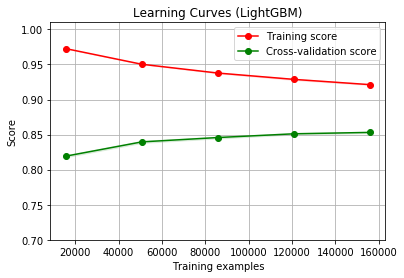

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

features = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'lat', 'lng', 'fecha', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'clustering_label', 'idf_titulo',
       'idf_descripcion', 'peso_titulo', 'peso_descripcion',
       'porcentaje_metros', 'diferencia_metros', 'metros_totales_normalizados',
       'metros_cubiertos_normalizados', 'escomercial',
       'promedio_metros_tipo_propiedad', 'promedio_metros_cub_tipo_propiedad',
       'prop_frecuente', 'top_provincia', 'es_ciudad_centrica',
       'promedio_metros_totales_provincia',
       'promedio_metros_cubiertos_provincia', 'mes', 'dia', 'trimestre',
       'dias_desde_datos', 'meses_desde_datos', 'antiguedad_bins_perc',
       'cantidad_inquilinos', 'tam_ambientes', 'promedio_precio_provincia',
       'promedio_precio_ciudad', 'varianza_precio_ciudad', 'count_ciudad',
       'promedio_id_zona', 'promedio_id_zona_gen', 'varianza_id_zona',
       'count_id_zona', 'promedio_precio_tipo_propiedad',
       'promedio_precio_tipo_propiedad_ciudad',
       'promedio_precio_tipo_propiedad_ciudad_gen', 'count_tipo_propiedad',
       'count_tipo_propiedad_ciudad', 'promedio_por_mes', 'varianza_por_mes',
       'promedio_precio_habitaciones',
       'promedio_precio_habitaciones_banos_garages',
       'promedio_precio_banos_garages', 'promedio_precio_hbg_tipo_propiedad',
       'lat_norm', 'lng_norm', 'promedio_precio_booleanos', 'puntaje',
       'distancia_ciudad_centrica', 'distancia_centro_mexico',
       'distancia_ciudad_cara']

title = "Learning Curves (LightGBM)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

params = {'reg_lambda': 6,
'objective': 'regression',
'num_leaves': 300,
'n_jobs': 4,
'min_split_gain': 0.05,
'min_data_in_leaf': 20,
'metric': 'mae',
'max_depth': 10,
'max_bin': 175,
'learning_rate': 0.15,
'feature_fraction': 0.85,
'boosting_type': 'gbdt',
'bagging_freq': 0,
'bagging_fraction': 0.3}

gbm = lgb.LGBMRegressor(**params)

plot_learning_curve(gbm, title, utils.filtrar_features(df_train_f, features).values, df_train_f['precio'].values, 
                    ylim=(0.7, 1.01), cv=3, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

plt.show()


In [ ]:
import shap 
# shap.initjs()

df_test_shap = utils.filtrar_features(df_test_f, features)

explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(df_test_shap)

In [ ]:
# shap.force_plot(explainer.expected_value, shap_values, df_test_shap)

In [ ]:
shap.summary_plot(shap_values, df_test_shap)

## Evaluación df_test completo

In [ ]:
df_train = pd.read_csv('./data/train.csv',)

# Para usarse con el submit a Kaggle
df_test = pd.read_csv('./data/test.csv')

df_test = features.llenar_nulls(df_test, hgb_mean=True)
df_train = features.llenar_nulls(df_train, hgb_mean=True)

df_test_f = features.features_independientes_precio(df_test)
df_test_f = features.features_dependientes_precio(df_test_f, df_train)

df_train_f = features.features_independientes_precio(df_train)
df_train_f = features.features_dependientes_precio(df_train_f, df_train)

df_test_f, cols_tipodepropiedad_ohe = features.columna_a_ohe(df_test_f, 'tipodepropiedad', N=250, df_aux=df_train, devolver_cols=True)
df_test_f, cols_provincia_ohe = features.columna_a_ohe(df_test_f, 'provincia', N=250, df_aux=df_train, devolver_cols=True)
df_test_f, cols_zona_ohe = features.columna_a_ohe(df_test_f, 'zona', N=250, df_aux=df_train_f, devolver_cols=True)

df_train_f = features.columna_a_ohe(df_train_f, 'tipodepropiedad', N=250, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'provincia', N=250, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'zona', N=250, df_aux=df_test_f)

df_train_f = f_textos.features_textos(df_train_f)
df_test_f = f_textos.features_textos(df_test_f)

# df_train_f['fecha'] = pd.to_datetime(df_train_f['fecha']).astype(int)
# df_test_f['fecha'] = pd.to_datetime(df_test_f['fecha']).astype(int)


features =['antiguedad', 'garages', 'metroscubiertos', 'lng', 'fecha',
       'porcentaje_metros', 'dia', 'dias_desde_datos', 'tam_ambientes',
       'metros_totales_normalizados', 'varianza_precio_ciudad', 'count_ciudad',
       'promedio_id_zona', 'count_id_zona',
       'promedio_precio_tipo_propiedad_ciudad', 'count_tipo_propiedad_ciudad',
       'varianza_por_mes', 'promedio_precio_habitaciones_banos_garages',
       'lat_norm', 'puntaje', 'idf_titulo', 'idf_descripcion',
       'peso_descripcion', 'distancia_ciudad_centrica',
       'distancia_centro_mexico']

# hps = {'bagging_fraction': 0.806451877022587,
#  'bagging_freq': 62.0,
#  'feature_fraction': 0.5379925983440028,
#  'learning_rate': 0.1363027714646826,
#  'max_depth': 11.0,
#  'num_leaves': 113.0,
#  'test_size': 0.09575190901892519}


hps = {'bagging_fraction': 0.8988911725316586,
 'bagging_freq': 22.0,
 'feature_fraction': 0.6622442122619671,
 'learning_rate': 0.16422725363286422,
 'max_depth': 22.0,
 'num_leaves': 180.0,
 'test_size': 0.13892455926004772}


bagging_fraction = hps['bagging_fraction']
bagging_freq = int(hps['bagging_freq'])
feature_fraction = hps['feature_fraction']
learning_rate = hps['learning_rate']
num_leaves = int(hps['num_leaves'])
max_depth = int(hps['max_depth'])
test_size = hps['test_size']

params = {
    'boosting_type': 'dart',
    'objective': 'regression',
    'metric': {'mae'}, # Si se deja vacio se toma el ideal para llegar al 'objective'
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,
    'feature_fraction': feature_fraction,
    'bagging_fraction': bagging_fraction,
    'bagging_freq': bagging_freq,
    'max_depth': max_depth,
    'verbose': 0
}

x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features, test_size=test_size)

lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)


gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_eval,
                num_boost_round=1000,
                early_stopping_rounds=15,
                verbose_eval=1)

y_pred_test = gbm.predict(x_test, raw_score=True, num_iteration=gbm.best_iteration)
y_pred_train = gbm.predict(x_train, raw_score=True, num_iteration=gbm.best_iteration)
y_pred_eval = gbm.predict(utils.filtrar_features(df_test_f, features), num_iteration=gbm.best_iteration)

gbm_mae_train = utils.MAE(y_train, y_pred_train)
gbm_mae = utils.MAE(y_test, y_pred_test)

print(f"MAE LightGBM (train): {gbm_mae_train:.5f}")
print(f"MAE LightGBM (test): {gbm_mae:.5f}")

In [ ]:
y_pred_eval = gbm.predict(utils.filtrar_features(df_test_f, features), num_iteration=gbm.best_iteration)
df_test_f['target'] = y_pred_eval

# df_test_f = utils.pesificar_df(df_test_f, 'target', 'target')
df_test_f[['id', 'target']].to_csv('respuesta25.csv', index=False)

In [ ]:
utils.filtrar_features(df_test_f, features).columns.equals(x_train.columns)

In [ ]:
df_test_f.shape